You are given a 11x11 maze. The start point is at (1, 0), the end is at (9, 10). Walls ('#') are impassable, free ('.') traversable. Return ONLY a Python list of (row,col) tuples (including start/end), no explanations.
###########
....#.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########

Make sure not to repeat prior mistakes



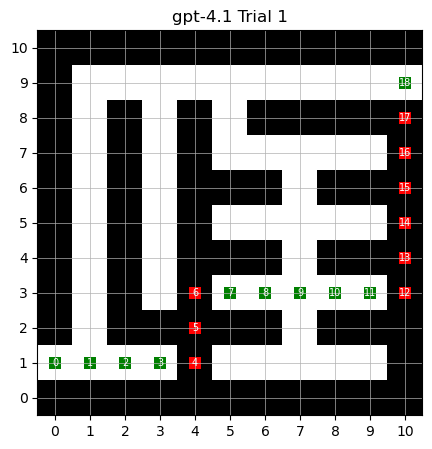

You are given a 11x11 maze. The start point is at (1, 0), the end is at (9, 10). Walls ('#') are impassable, free ('.') traversable. Return ONLY a Python list of (row,col) tuples (including start/end), no explanations.
###########
....#.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########
\Here's your previous attempt 1 overlay until you hit a wall (1=valid,0=error):
###########
11110.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########

Make sure not to repeat prior mistakes



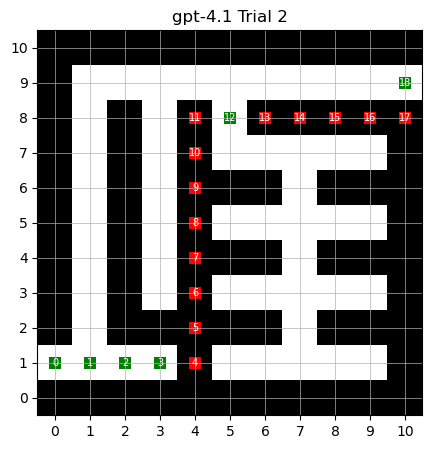

You are given a 11x11 maze. The start point is at (1, 0), the end is at (9, 10). Walls ('#') are impassable, free ('.') traversable. Return ONLY a Python list of (row,col) tuples (including start/end), no explanations.
###########
....#.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########
\Here's your previous attempt 1 overlay until you hit a wall (1=valid,0=error):
###########
11110.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########
\Here's your previous attempt 2 overlay until you hit a wall (1=valid,0=error):
###########
11110.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########

Make sure not to repeat prior mistakes



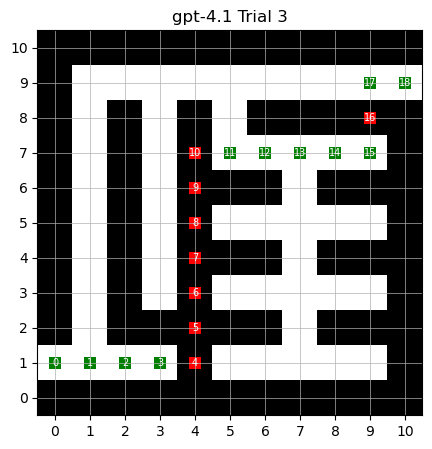

You are given a 11x11 maze. The start point is at (1, 0), the end is at (9, 10). Walls ('#') are impassable, free ('.') traversable. Return ONLY a Python list of (row,col) tuples (including start/end), no explanations.
###########
....#.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########
\Here's your previous attempt 1 overlay until you hit a wall (1=valid,0=error):
###########
11110.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########
\Here's your previous attempt 2 overlay until you hit a wall (1=valid,0=error):
###########
11110.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########
\Here's your previous attempt 3 overlay until you hit a wall (1=valid,0=error):
###########
11110.....#
#.#####.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.###.###
#.#.#.....#
#.#.#.#####
#..........
###########

Make sure no

KeyboardInterrupt: 

In [50]:
import time
import json
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from openai import OpenAI
from typing import Callable, Dict, List, Tuple, Any
from mazes import Mazes


class MazeSolverResult:
    def __init__(
        self,
        llm_name: str,
        maze_id: Tuple[int, int],
        path: List[Tuple[int, int]],
        valid: bool,
        solve_time: float,
        raw_response: str,
        source_file: str,
        history: List[Dict[str, Any]],
    ):
        self.llm_name = llm_name
        self.maze_id = maze_id
        self.path = path
        self.valid = valid
        self.solve_time = solve_time
        self.raw_response = raw_response
        self.source_file = source_file
        self.history = history

    def to_dict(self) -> Dict:
        return {
            "llm_name": self.llm_name,
            "grid_dim": self.maze_id[0],
            "maze_number": self.maze_id[1],
            "path": self.path,
            "valid": self.valid,
            "solve_time": self.solve_time,
            "raw_response": self.raw_response,
            "history": self.history,
            "source_file": self.source_file,
        }

    def __str__(self) -> str:
        status = "Success" if self.valid else "Failure"
        return f"[{self.llm_name}] {os.path.basename(self.source_file)} - {status} ({self.solve_time:.3f}s)"


class MazeTester:
    def __init__(
        self,
        llm_callables: Dict[str, Callable[[str], str]],
        maze_loader: Callable[[str], Mazes],
        max_trials: int = 5,
    ):
        self.llm_callables = llm_callables
        self.maze_loader = maze_loader
        self.max_trials = max_trials
        self.results: List[MazeSolverResult] = []

    def _format_base_prompt(self, maze: Mazes) -> str:
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        rows = [''.join('#' if cell else '.' for cell in row) for row in maze.grid]
        maze_str = "\n".join(rows)
        return (
            f"You are given a {dim}x{dim} maze. The start point is at {start}, the end is at {end}."
            " Walls ('#') are impassable, free ('.') traversable."
            " Return ONLY a Python list of (row,col) tuples (including start/end), no explanations."
            f"\n{maze_str}"
        )

    def _parse_response(self, response: str) -> List[Tuple[int, int]]:
        list_pat = r"\[(?:\s*\(\d+,\s*\d+\s*\)(?:,\s*\(\d+,\s*\d+\s*\))*)\]"
        match = re.search(list_pat, response)
        if match:
            coords = re.findall(r"\((\d+),\s*(\d+)\)", match.group(0))
            return [(int(r), int(c)) for r, c in coords]
        for line in response.splitlines():
            if '[' in line and ']' in line:
                try:
                    cand = ast.literal_eval(line[line.find('['):line.rfind(']')+1])
                    if isinstance(cand, list) and all(isinstance(p, tuple) for p in cand):
                        return cand
                except:
                    pass
        return []

    def _validate_first(self, maze: Mazes, path: List[Tuple[int, int]]) -> Tuple[bool, List[int]]:
        # Returns validity and list containing only the first invalid index
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        invalid = []
        if not path or path[0] != start:
            return False, [0]
        for idx, (prev, curr) in enumerate(zip(path, path[1:]), start=1):
            r1, c1 = prev; r2, c2 = curr
            if not (0 <= r2 < dim and 0 <= c2 < dim) or maze.grid[r2, c2] == 1 or abs(r1-r2)+abs(c1-c2) != 1:
                return False, [idx]
        if path[-1] != end:
            return False, [len(path)-1]
        return True, []

    def _validate_all(self, maze: Mazes, path: List[Tuple[int, int]]) -> List[int]:
        # Returns all invalid indices without breaking
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        invalid = []
        if not path or path[0] != start:
            invalid.append(0)
        for idx, (prev, curr) in enumerate(zip(path, path[1:]), start=1):
            r1, c1 = prev; r2, c2 = curr
            if not (0 <= r2 < dim and 0 <= c2 < dim) or maze.grid[r2, c2] == 1 or abs(r1-r2)+abs(c1-c2) != 1:
                invalid.append(idx)
        if path and path[-1] != end:
            invalid.append(len(path)-1)
        return invalid

    def _plot(self, maze: Mazes, path: List[Tuple[int,int]], invalid_all: List[int], name: str, t: int):
        dim = maze.grid.shape[0]
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(maze.grid, cmap=colors.ListedColormap(['white','black']), origin='upper')
        ax.set_title(f"{name} Trial {t}")
        ax.set_xticks(range(dim)); ax.set_yticks(range(dim)); ax.grid(True, linewidth=0.5)
        for i, (r, c) in enumerate(path):
            col = 'red' if i in invalid_all else 'green'
            ax.scatter(c, r, c=col, s=80, marker='s', edgecolors='none')
            ax.text(c, r, str(i), va='center', ha='center', color='white', fontsize=7)
        ax.invert_yaxis()
        plt.show()

    def solve_maze(self, filename: str):
        maze = self.maze_loader(filename)
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        base = self._format_base_prompt(maze)
        for name, fn in self.llm_callables.items():
            history = []
            final = []
            valid = False
            start_time = time.time()
            for trial in range(1, self.max_trials+1):
                prompt = base
                for i, h in enumerate(history, 1):
                    _, first_invalid = self._validate_first(maze, h['path'])
                    fb = first_invalid[0]
                    # build overlay mask for prompt
                    mask = np.array([['#' if maze.grid[r,c] else '.' for c in range(dim)] for r in range(dim)], dtype=str)
                    for j, (r, c) in enumerate(h['path'][:fb]):
                        mask[r, c] = '1'
                    br, bc = h['path'][fb]
                    mask[br, bc] = '0'
                    overlay = '\n'.join(''.join(row) for row in mask)
                    prompt+= f"\n\Here's your previous attempt {i} overlay until you hit a wall (1=valid,0=error):\n{overlay}"
                prompt += f"\n\nMake sure not to repeat prior mistakes\n"
                print(prompt)
                resp = fn(prompt)
                path = self._parse_response(resp)
                ok, first_inv = self._validate_first(maze, path)
                all_inv = self._validate_all(maze, path)
                history.append({'path': path, 'invalid_first': first_inv, 'invalid_all': all_inv})
                self._plot(maze, path, all_inv, name, trial)
                if ok:
                    final = path; valid = True; break
            self.results.append(
                MazeSolverResult(name, (dim, maze.maze_number), final, valid,
                                 time.time() - start_time, str(final), filename, history)
            )

    def test_many(self, files: List[str]) -> List[MazeSolverResult]:
        for f in files:
            self.solve_maze(f)
        return self.results

    def save_results(self, out_file: str) -> None:
        with open(out_file, 'w') as f:
            json.dump([r.to_dict() for r in self.results], f, indent=2)

    def summary(self) -> Dict[str, Dict[str, float]]:
        stats: Dict[str, Dict[str, float]] = {}
        for r in self.results:
            m = stats.setdefault(r.llm_name, {"total":0, "successes":0, "time":0.0})
            m['total'] += 1
            m['successes'] += int(r.valid)
            m['time'] += r.solve_time
        for s in stats.values():
            s['avg_time'] = s['time'] / s['total']
            s['success_rate'] = s['successes'] / s['total']
        return stats

    def display_solutions(self) -> None:
        for res in self.results:
            print(str(res))

    def display_solution_overlay(self, result: MazeSolverResult) -> None:
        maze = self.maze_loader(result.source_file)
        path = result.path
        grid_dim = maze.grid.shape[0]
        start = (1, 0)
        end = (grid_dim - 2, grid_dim - 1)

        valid_steps = [path and path[0] == start]
        for prev, curr in zip(path, path[1:]):
            r1, c1 = prev
            r2, c2 = curr
            in_bounds = 0 <= r2 < grid_dim and 0 <= c2 < grid_dim
            not_wall = in_bounds and (maze.grid[r2, c2] == 0)
            adj = abs(r1 - r2) + abs(c1 - c2) == 1
            valid_steps.append(in_bounds and not_wall and adj)

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(maze.grid, cmap=colors.ListedColormap(['white', 'black']), origin='upper')
        ax.set_title(f"{result.llm_name} Solution Overlay - {'Valid' if result.valid else 'Invalid'}")
        ax.set_xticks(range(grid_dim)); ax.set_yticks(range(grid_dim))
        ax.grid(which='both', color='lightgray', linewidth=0.5)

        for idx, ((r, c), ok) in enumerate(zip(path, valid_steps)):
            ax.scatter(c, r, c='green' if ok else 'red', s=100, marker='s', edgecolors='none')
            ax.text(c, r, str(idx), va='center', ha='center', color='white', fontsize=8)

        ax.invert_yaxis()
        plt.show()

    def display_all_overlays(self) -> None:
        for res in self.results:
            self.display_solution_overlay(res)


if __name__ == "__main__":

    def make_openai_callable(model: str) -> Callable[[str], str]:
        return lambda prompt: client.responses.create(
            model=model,
            instructions="You are an expert maze solver.",
            input=prompt,
            #temperature=0
        ).output_text

    llm_map = {
        "gpt-4.1": make_openai_callable("gpt-4.1"),

    }

    tester = MazeTester(llm_map, Mazes.load)
    files = ["mazes/maze_5x5_8.json",]
    tester.test_many(files)
    tester.save_results("llm_maze_results.json")

    print("All solutions (text):")
    tester.display_solutions()

    print("Visual overlays:")
    tester.display_all_overlays()

    print("Summary:")
    for model, stats in tester.summary().items():
        print(f"- {model}: {stats['successes']}/{stats['total']} solved "
              f"({stats['success_rate']:.0%}), avg {stats['avg_time']:.3f}s")
